### Практическое задание к уроку 7
Реализовать иерархическую кластеризацию с любой из межкластерных метрик, кроме рассмотренной на вебинаре(Average Linkage Distance).

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import make_blobs
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
%matplotlib inline

In [2]:
X, y = make_blobs(n_samples=100, random_state=1)

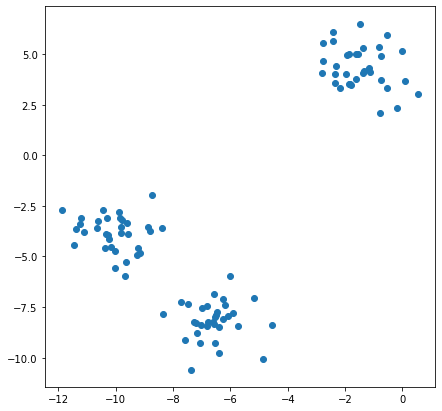

In [3]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])

In [4]:
# Расчет евклидовой метрики
def e_metrics(x1, x2):
    return np.sqrt(np.sum((x2-x1)**2))

In [5]:
# Алгоритм поиска k ближайших соседей
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

In [6]:
# Функция визуализации кластеров
def visualize(centroids, classes):
    colors = ['r', 'g', 'b', 'm']
    
    plt.figure(figsize=(7,7))
    
    # нанесем на график центроиды
    for centroid in centroids:
        plt.scatter(centroid[0], centroid[1], marker='x', s=130, c='black')
        
    # нанесем объекты раскрашенные по классам
    for class_item in classes:
        for x in classes[class_item]:
            plt.scatter(x[0], x[1], color=colors[class_item])
            
    plt.show()

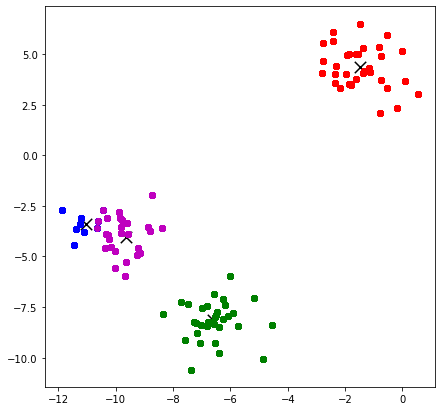

In [7]:
max_iterations = 25
min_distance = 1e-4

centroids, clusters = kmeans(X, 4, max_iterations, min_distance)

visualize(centroids, clusters)

Реализовал два вида межкластерных метрик: Centroid Linkage Distance (строка 2) и Average Centroid Linkage Distance (строка 8)

In [8]:
# Centroid Linkage Distance
def mean_dist(s_clast, t_clast):
    vs = sum(s_clast) / len(s_clast)
    vt = sum(t_clast) / len(t_clast)
    return e_metrics(vs, vt)

# Average Centroid Linkage Distance
# def mean_dist(s_clast, t_clast):
#     vs = sum(s_clast) / len(s_clast)
#     vt = sum(t_clast) / len(t_clast)
#     return ((sum(e_metrics(x, vt) for x in s_clast) + sum(e_metrics(y, vs) for y in t_clast))) / (len(s_clast)*len(t_clast))

def dist_matrix(clusters):
    matrix=np.zeros((len(clusters), len(clusters)))
    for i, u in enumerate(clusters):
        for j, v in enumerate(clusters[i+1:], start=i+1):
            matrix[[i, j], [j, i]]=mean_dist(u, v)
    return matrix

In [9]:
def indexes_to_combine(dist_matrix):
    min_el=dist_matrix[np.triu_indices(dist_matrix.shape[0], 1)].min()
    return np.argwhere(dist_matrix==min_el)[0], min_el

In [10]:
def exclude_clusters(i, j, dist_matrix):
    mask=np.ones(dist_matrix.shape[0], dtype=bool)
    mask[i]=False
    mask[j]=False
    return dist_matrix[mask, :][:, mask]

def merge_clusters(i, j, clusters):
    new_cluster=clusters[i]+clusters[j]
    return new_cluster, [c for k, c in enumerate(clusters) if not k in [i, j]]

def include_cluster(dist_mat, old_clusters, new_cluster):
    new_col=np.array([mean_dist(c, new_cluster) for c in old_clusters])[:, np.newaxis]
    dist_mat=np.concatenate([dist_mat, new_col], axis=1)
    new_row=np.concatenate([new_col.flatten(), [0]])[np.newaxis, :]
    dist_mat=np.concatenate([dist_mat, new_row], axis=0)
    return dist_mat

In [11]:
def hierarchy_clustering(cluster_list):
    cluster_list=cluster_list[:]
    dist_mat=dist_matrix(cluster_list)
    cluster_numbers=list(range(len(cluster_list)))
    z=[]
    new_num=len(cluster_list)
    while len(cluster_list)>1:
        [i, j], min_val=indexes_to_combine(dist_mat)
        dist_mat=exclude_clusters(i, j, dist_mat)
        new_cluster, old_clusters=merge_clusters(i, j, cluster_list)
        dist_mat=include_cluster(dist_mat, old_clusters, new_cluster)
        z.append([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
        print([cluster_numbers[i], cluster_numbers[j], min_val, len(new_cluster)])
        cluster_list=old_clusters+[new_cluster]
        cluster_numbers=[n for k, n in enumerate(cluster_numbers) if not k in [i, j]]+[new_num]
        new_num+=1
    return z

Проверяю работу алгоритма иерархической кластеризации

In [12]:
cluster_keys = list(clusters.keys())
cluster_data = [clusters[k] for k in cluster_keys]

In [13]:
Z = hierarchy_clustering(cluster_data)

[2, 3, 1.5381173720716417, 815]
[1, 4, 5.494256261396432, 1650]
[0, 5, 12.4111529263445, 2500]


При использовании обоих межкластерных метрик получается результ, аналогичный полученному на уроке с метрикой Average Linkage Distance.  
Визуализирую получившийся результат.

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [5.0, 5.0, 22.5, 22.5]],
 'dcoord': [[0.0, 1.5381173720716417, 1.5381173720716417, 0.0],
  [0.0, 5.494256261396432, 5.494256261396432, 1.5381173720716417],
  [0.0, 12.4111529263445, 12.4111529263445, 5.494256261396432]],
 'ivl': ['r', 'g', 'b', 'm'],
 'leaves': [0, 1, 2, 3],
 'color_list': ['C1', 'C1', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1']}

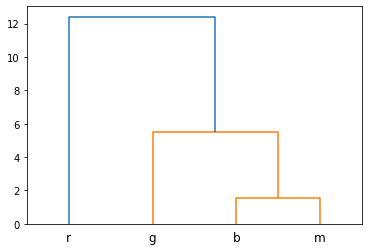

In [14]:
hierarchy.dendrogram(Z, labels= ['r', 'g', 'b', 'm'])